In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from matplotlib import pyplot as plt


#print(device_lib.list_local_devices())


( train_dataset , test_dataset ) , ds_info = tfds.load ("mnist", split =["train", "test"], as_supervised = True , with_info = True )


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\cdmei\tensorflow_datasets\mnist\3.0.1.incomplete8EZW9S\mnist-train.tfrecord*...:   0%|     …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\cdmei\tensorflow_datasets\mnist\3.0.1.incomplete8EZW9S\mnist-test.tfrecord*...:   0%|      …

Dataset mnist downloaded and prepared to C:\Users\cdmei\tensorflow_datasets\mnist\3.0.1. Subsequent calls will reuse this data.


In [2]:

#tfds.show_examples(train_ds, ds_info)

# • How many training/test images are there?

print("length of train dataset: ", len(train_dataset), "length of test dataset: ",  len(test_dataset))

# • What’s the image shape?

# ds_info tells us: 'image': Image(shape=(28, 28, 1), dtype=uint8),

# • What range are pixel values in?

# not that efficient, but gives the correct answer of 255
"""best_max_value = 0
for elem in train_ds:
  max_val = np.max(elem[0].numpy())
  if max_val > best_max_value:
    best_max_value = max_val

print("highest value of pixel: ", best_max_value)"""

length of train dataset:  60000 length of test dataset:  10000


'best_max_value = 0\nfor elem in train_ds:\n  max_val = np.max(elem[0].numpy())\n  if max_val > best_max_value:\n    best_max_value = max_val\n\nprint("highest value of pixel: ", best_max_value)'

In [3]:
#ds_info

In [4]:
def preprocess_data(dataset, batchsize=32):
  # 1. change datatype from uint8 into float values
  dataset = dataset.map(lambda img, target: (tf.cast(img, tf.float32), target))

  # 2. flatten the image
  dataset = dataset.map(lambda img, target: (tf.reshape(img, (-1, )), target))

  # 3. normalize from 0 - 255 into -1 - 1
  dataset = dataset.map(lambda img, target: (img/128.0 - 1, target))

  # 4. one-hot encode the targets
  dataset = dataset.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

  dataset = dataset.cache()
  dataset = dataset.shuffle(1000)
  dataset = dataset.batch(batchsize)
  dataset = dataset.prefetch(28)
  return dataset

In [5]:
class MNIST_predictor(tf.keras.Model):
    
    def __init__(self, layer_list_new):
        super(MNIST_predictor, self).__init__()
        self.layer_list = layer_list_new

    #@tf.function
    def call(self, x):
        for layer in self.layer_list:
          x = layer(x)
        return x

In [6]:
# • The number of epochs
EPOCHS = 10

# • The loss function
loss_fct = tf.keras.losses.CategoricalCrossentropy()

# train and test ds
batch_size_list = [4, 32, 1024]


train_ds_list = []
test_ds_list = []
for bs in batch_size_list:
    train_dataset, test_dataset = tfds.load ("mnist", split =["train", "test"], as_supervised = True)
    train_ds_list.append(train_dataset.apply(preprocess_data))
    test_ds_list.append(test_dataset.apply(preprocess_data))


# learning rates
learning_rate_list = [0.01, 0.1, 0.5]

#momentums
momentum_list = [0.01, 0.2, 0.9]


optimizer_list = [tf.keras.optimizers.legacy.SGD(learning_rate=ll, momentum=mm) for ll, mm in zip(learning_rate_list, momentum_list)]

layer_list = [
    [ # number 0, large network
        tf.keras.layers.Dense(256, activation=tf.nn.relu),
        tf.keras.layers.Dense(256, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ],
    [ # number 1, medium network
        tf.keras.layers.Dense(64, activation=tf.nn.relu),
        tf.keras.layers.Dense(64, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ],
    [ # number 2, small network
        tf.keras.layers.Dense(8, activation=tf.nn.relu),
        tf.keras.layers.Dense(8, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ]
]

model_list = [MNIST_predictor(layer_list_new=ll) for ll in layer_list]

In [7]:
#@tf.function
def test_step(x, y, model, loss_function):
    predictions = model(x, training=False)
    loss = loss_function(y, predictions) # why?  + tf.reduce_sum(self.losses)
    return loss, predictions


#@tf.function
def train_step(x, y, model, loss_function, optimizer):
  with tf.GradientTape() as tape:
      predictions = model(x)
      loss = loss_function(y, predictions)

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss, predictions



def train_loop(epochs,
               train_ds,
               test_ds,
               loss_function,
               optimizer,
               model):

    train_losses = []
    train_accuracys = []
    test_losses = []
    test_accuracys = []

    print("epoch: ", end= " ")

    for epoch in range(EPOCHS):
      print(epoch,", " ,end=" ")
      train_loss = []
      train_acc = []
      test_loss = []
      test_acc = []
      
      # training
      for x, y in train_ds:
        loss, predictions = train_step(x, y, model, loss_function, optimizer)
        correct = np.argmax(predictions, axis=1) == np.argmax(y, axis=1)

        train_loss.append(loss)
        train_acc.append(np.mean(correct))

      train_losses.append(tf.reduce_mean(train_loss).numpy())
      train_accuracys.append(tf.reduce_mean(train_acc).numpy())
      #print("training loss: ", train_losses)

      # testing
      for x, y in test_ds:
        loss, predictions = test_step(x, y, model, loss_function)
        correct = np.argmax(predictions, axis=1) == np.argmax(y, axis=1)
        test_loss.append(loss)
        test_acc.append(np.mean(correct))

      test_losses.append(tf.reduce_mean(test_loss).numpy())
      test_accuracys.append(tf.reduce_mean(test_acc).numpy())
      #print("test loss: ", test_losses, "\ntest_acc: ", test_accuracys, "\n")
    
    return train_losses, test_losses, train_accuracys, test_accuracys

    


training with
batchsize: 4 
learning rate:  0.01 
momentum:  0.01 
model_number:  0
epoch:  0 ,  1 ,  2 ,  3 ,  4 ,  5 ,  6 ,  7 ,  8 ,  9 ,  
performance levels at the end:
train_loss:  0.07184624 
test_loss:  0.08766385 
train_accuracy:  0.9794166666666667 
test_accuracy 0.9729432907348243

training with
batchsize: 4 
learning rate:  0.01 
momentum:  0.01 
model_number:  1
epoch:  0 ,  1 ,  2 ,  3 ,  4 ,  5 ,  6 ,  7 ,  8 ,  9 ,  
performance levels at the end:
train_loss:  0.102699 
test_loss:  0.110783085 
train_accuracy:  0.9696666666666667 
test_accuracy 0.9674520766773163

training with
batchsize: 4 
learning rate:  0.01 
momentum:  0.01 
model_number:  2
epoch:  0 ,  1 ,  2 ,  3 ,  4 ,  5 ,  6 ,  7 ,  8 ,  9 ,  
performance levels at the end:
train_loss:  0.2991211 
test_loss:  0.28439766 
train_accuracy:  0.9152833333333333 
test_accuracy 0.919229233226837

training with
batchsize: 4 
learning rate:  0.1 
momentum:  0.2 
model_number:  0
epoch:  0 ,  1 ,  2 ,  3 ,  4 ,  5 ,  

C:\Users\cdmei\AppData\Local\Temp\ipykernel_28404\3326898364.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure ()


1 ,  2 ,  3 ,  4 ,  5 ,  6 ,  7 ,  8 ,  9 ,  
performance levels at the end:
train_loss:  14.546315 
test_loss:  14.547483 
train_accuracy:  0.09751666666666667 
test_accuracy 0.09744408945686901

training with
batchsize: 1024 
learning rate:  0.1 
momentum:  0.2 
model_number:  1
epoch:  0 ,  1 ,  2 ,  3 ,  4 ,  5 ,  6 ,  7 ,  8 ,  9 ,  
performance levels at the end:
train_loss:  14.526973 
test_loss:  14.536219 
train_accuracy:  0.09871666666666666 
test_accuracy 0.09814297124600639

training with
batchsize: 1024 
learning rate:  0.1 
momentum:  0.2 
model_number:  2
epoch:  0 ,  1 ,  2 ,  3 ,  4 ,  5 ,  6 ,  7 ,  8 ,  9 ,  
performance levels at the end:
train_loss:  14.5283165 
test_loss:  14.571623 
train_accuracy:  0.09863333333333334 
test_accuracy 0.09594648562300319

training with
batchsize: 1024 
learning rate:  0.5 
momentum:  0.9 
model_number:  0
epoch:  0 ,  1 ,  2 ,  3 ,  4 ,  5 ,  6 ,  7 ,  8 ,  9 ,  
performance levels at the end:
train_loss:  14.546315 
test_loss:  1

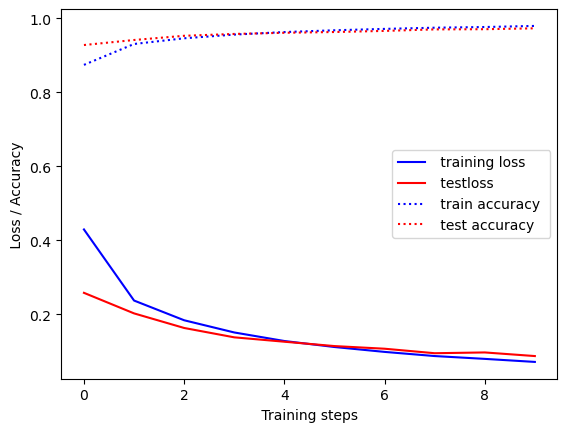

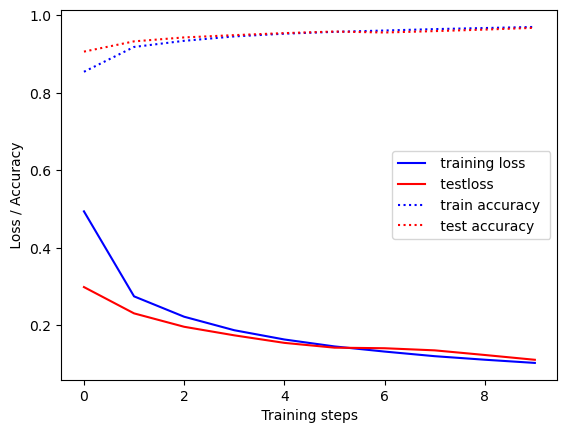

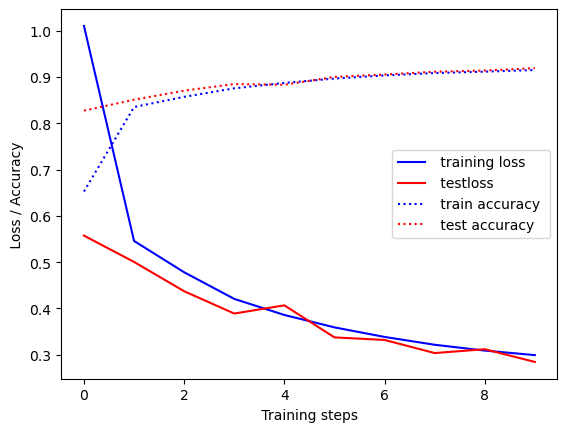

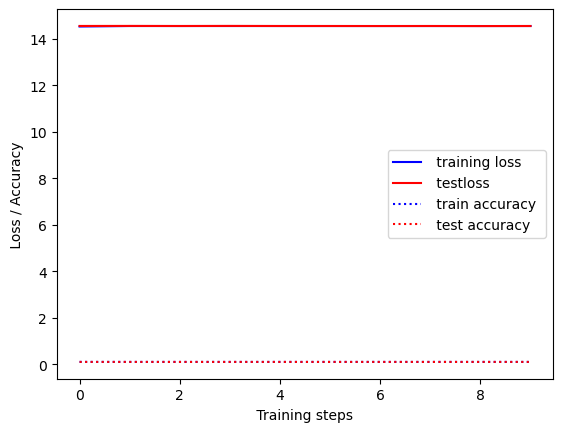

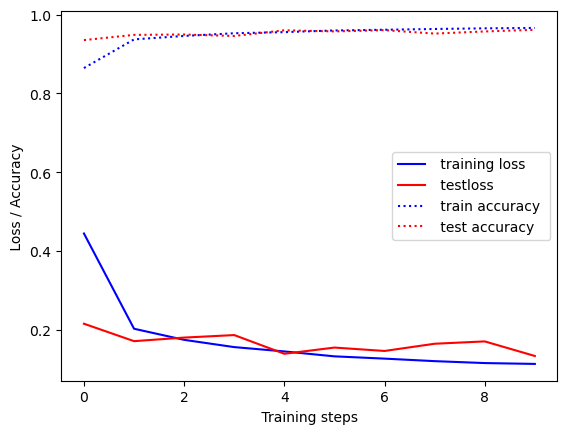

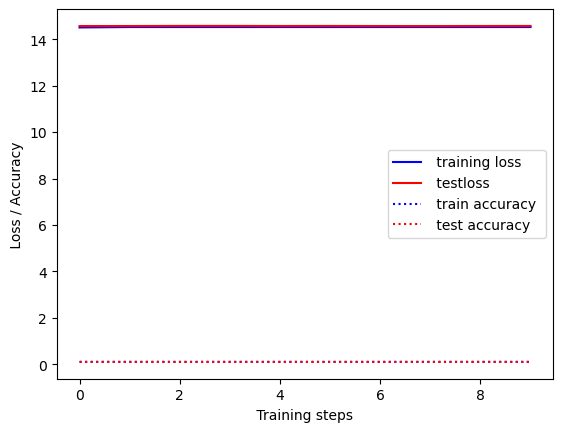

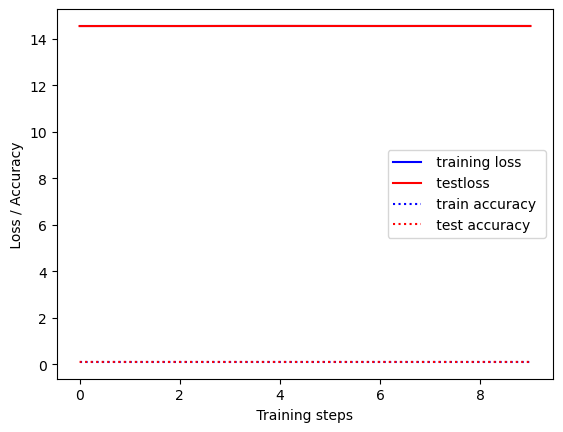

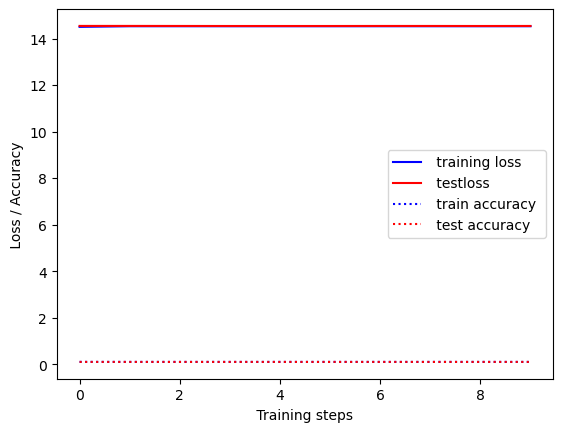

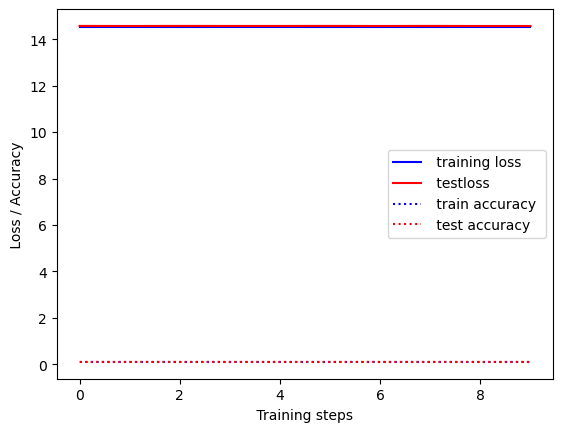

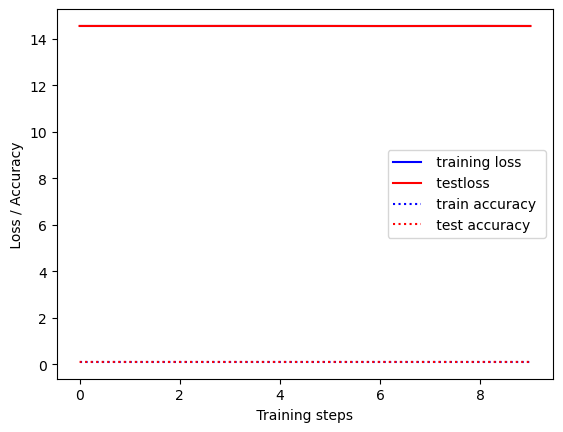

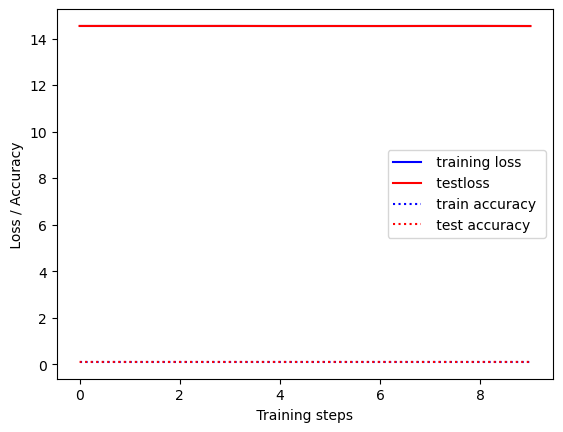

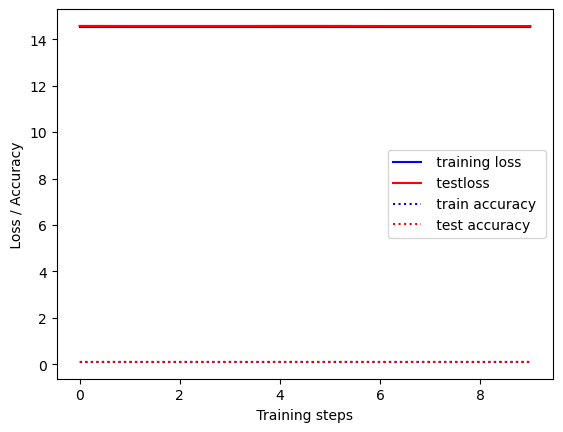

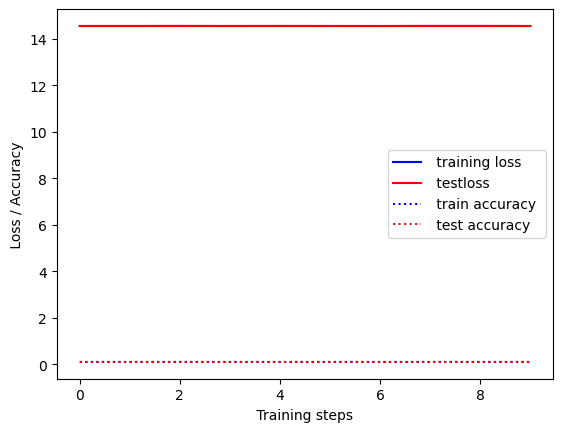

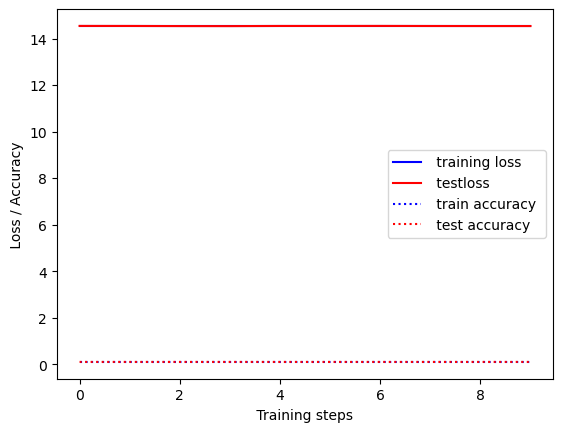

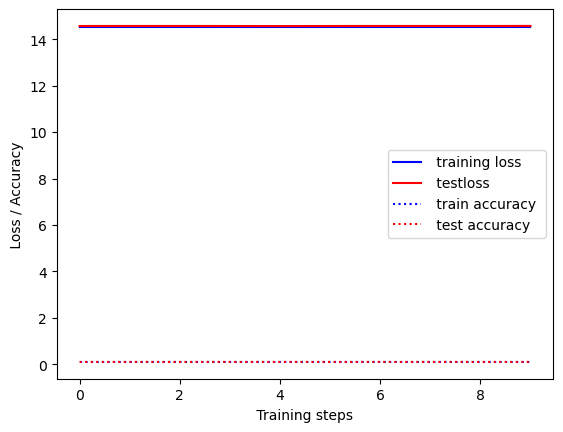

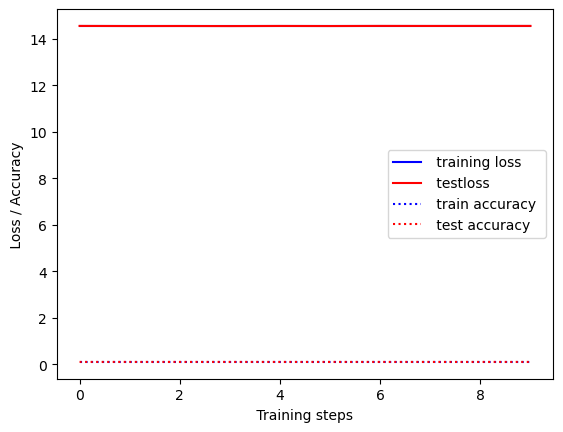

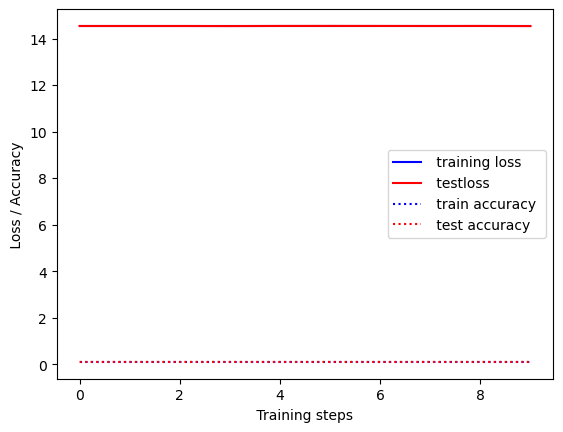

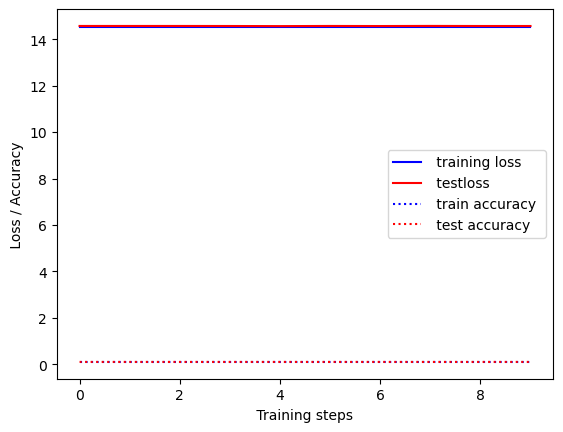

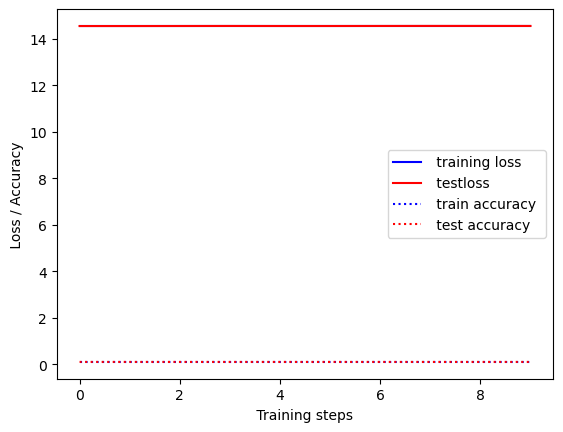

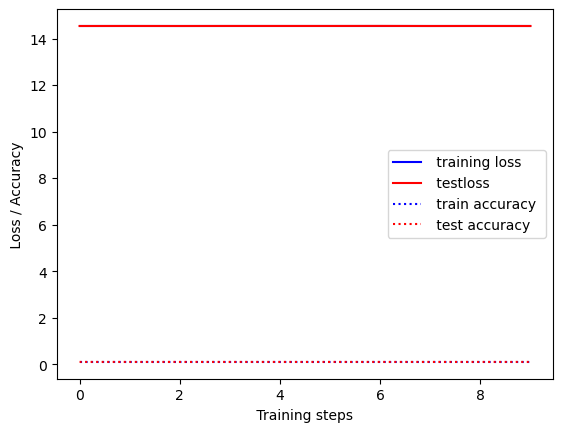

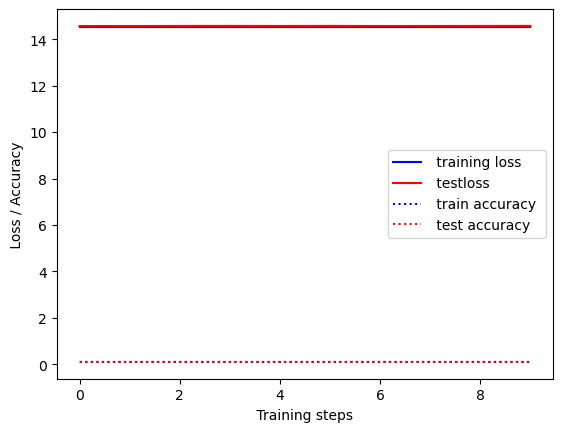

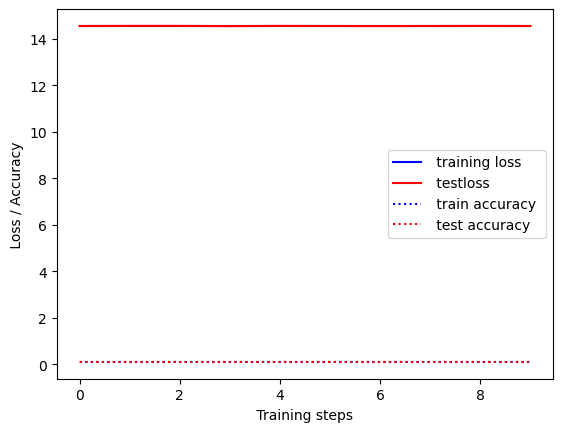

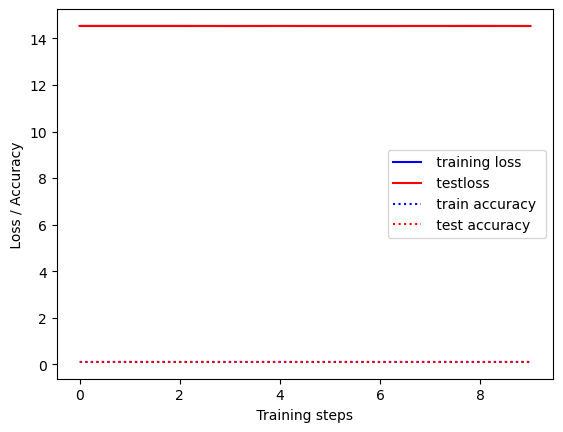

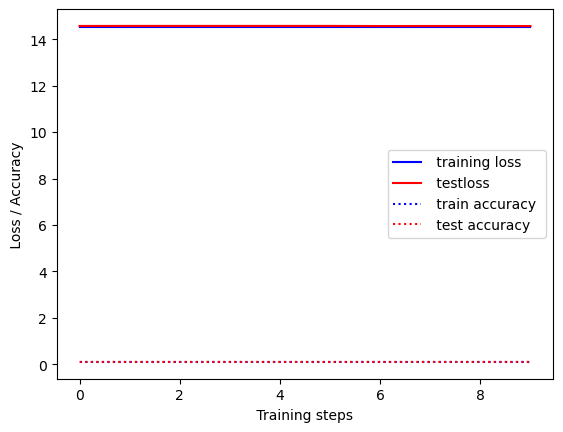

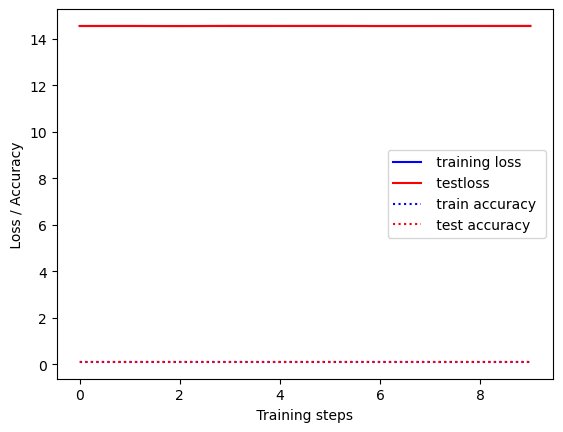

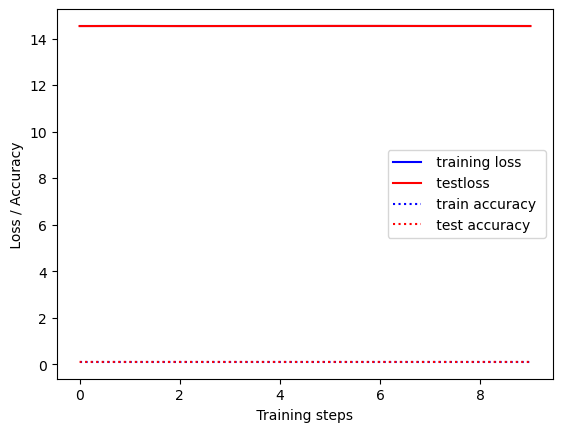

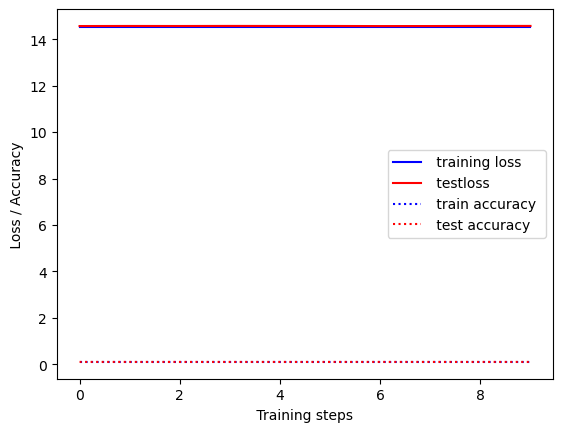

In [8]:
def visualization (train_losses, test_losses, train_accuracies, test_accuracies, name):
    plt.figure ()
    line1 , = plt.plot(train_losses , "b-")
    line2 , = plt.plot(test_losses , "r-")
    line3 , = plt.plot(train_accuracies , "b:")
    line4 , = plt.plot(test_accuracies , "r:")
    plt . xlabel (" Training steps ")
    plt . ylabel (" Loss / Accuracy ")
    plt . legend (( line1 , line2 , line3, line4 ) , (" training loss ", " testloss ", " train accuracy ", " test accuracy "))
    plt.savefig(name)

plt_list = []
for train_ds, test_ds, bs in zip(train_ds_list, test_ds_list, batch_size_list):
    for opt, lr, mm in zip(optimizer_list, learning_rate_list, momentum_list):
        for idx, model in enumerate(model_list):
            print("\ntraining with\nbatchsize:" , bs, "\nlearning rate: ", lr, "\nmomentum: ", mm, "\nmodel_number: ", idx)
            train_loss, test_loss, train_acc, test_acc = train_loop(EPOCHS, train_ds, test_ds, loss_fct, opt, model)
            
            print("\nperformance levels at the end:\ntrain_loss: ", train_loss[-1], "\ntest_loss: ", test_loss[-1],"\ntrain_accuracy: " ,train_acc[-1],"\ntest_accuracy" ,test_acc[-1])
            name = f"bs_{bs}_lr_{lr}_mm_{mm}_idx_{idx}.jpg"
            visualization(train_loss, test_loss, train_acc, test_acc, name)

# momentum 0.2 destroys everything


In [ ]:
# 3.Findings
"""With a batch size of 1024 or 32 non of the models (regardless of the other hyperparameters) 
were able to achieve a usable state. Only batchsize 4 yielded some usable results."""
"""When it comes to model size (only looking at batchsize=4), the small network with just 
8 perceptrons per layer was too small to learn how to recognize digits 
(somewhat reliable for lr=0.01 and mm=0.01). The larger model outperfromed the0 
meduim-sized model, but generally not by much."""
"""A learning rate of 0.1 or even 0.5 destroyed model performance, the same can be said 
for a momentum of 0.2 or even 0.9. There was only one exception, namely the medium-sized 
model using lr=0.1 and mm=0.2. For the momentum, this makes sense, since the metaphorical 
sledge overshoots the valley and ends up on a mountain again."""

